# Importing required Libraries and dataset

In [116]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

In [117]:
shape = 256
batch = 32

In [118]:
dataset = tf.keras.preprocessing.image_dataset_from_directory('PotatoImages',
                                                             batch_size= batch,
                                                             image_size= (shape,shape), shuffle = True)

Found 2152 files belonging to 3 classes.


In [5]:
classes = dataset.class_names
classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

# Visualising some images 

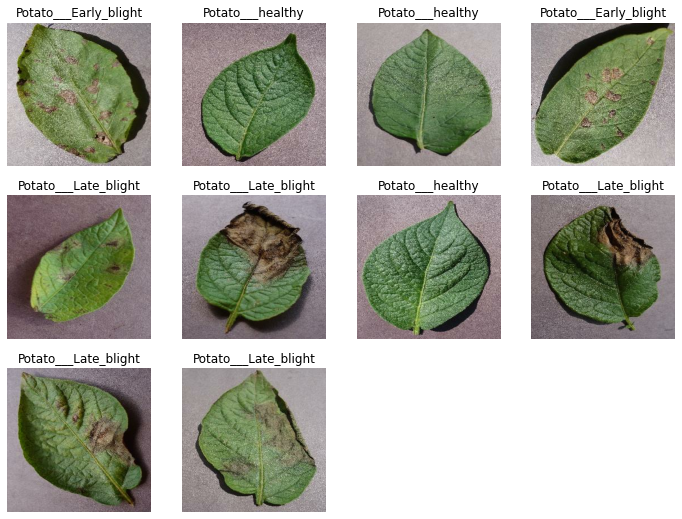

In [37]:
plt.figure(figsize = (12,9))
for image_batch, label_batch in dataset.take(1):
    for i in range(1,11):
        ax = plt.subplot(3,4,i)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(classes[label_batch[i]])
        plt.axis('off')

# Splitting dataset into train, validation and test sets

In [1]:
# trainsize = 80%
# validationsize = 10%
# testingsize = 10%

In [9]:
len(dataset)

68

In [10]:
0.8*len(dataset)

54.400000000000006

In [20]:
trainset = dataset.take(54)
len(trainset)

54

In [21]:
test_vals = dataset.skip(54)

In [22]:
valset = test_vals.take(7)
len(valset)

7

In [23]:
testset = test_vals.skip(7)
len(testset)

7

# Cache, shuffle and prefetch the data

In [29]:
trainset = trainset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valset = valset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
testset = testset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the CNN Model

Creating a Layer for Resizing and Normalization

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [34]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256,256),
  layers.experimental.preprocessing.Rescaling(1./255),
])

Data Augmentation

In order to avoid overfitting, we use Data Augmentation

In [38]:
data_augmentation = Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2)
])

# CNN Model 

Building a robust CNN model with many layers:
1) Here we are using our 'resize_and_reshape' and 'data_augmentation' that we build before in order to attain uniformity and to avoid overfitting.
2) We are building multiple Conv2d and Maxpool2d layers with 'ReLu' as activation function.
3) We are also using Dropout of 10%.
4) We are using Dense layer with 3 classes and we are using 'Softmax' as activation function.
5) We are using 'Adam' as optimzer, 'SparsecategoricalCrossentropy' as loss function and 'accuracy' as metric.
6) We are using 15 epochs to train our data and we also gave our 'valset' as validation_data.

In [47]:
inputshape = (batch, shape, shape, 3)
n_classes = len(classes)

model = Sequential()
model.add(resize_and_rescale)
model.add(data_augmentation)
model.add(Conv2D(filters = 64, kernel_size = 3,
                activation = 'relu', input_shape = inputshape))
model.add(MaxPool2D(pool_size = 2, strides =2))
model.add(Conv2D(filters = 64, kernel_size = 3,activation = 'relu'))
model.add(MaxPool2D(pool_size = 2, strides =2))
model.add(Conv2D(filters = 32, kernel_size = 3,activation = 'relu'))
model.add(MaxPool2D(pool_size = 2, strides =2))
model.add(Conv2D(filters = 32, kernel_size = 3,activation = 'relu'))
model.add(MaxPool2D(pool_size = 2, strides =2))
model.add(layers.Dropout(0.10))
model.add(Flatten())
model.add(Dense(64,activation = 'relu'))
model.add(Dense(units=n_classes, activation = 'softmax'))

model.build(input_shape= inputshape)

In [49]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_2 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (32, 254, 254, 64)        1792      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (32, 127, 127, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (32, 125, 125, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (32, 60, 60, 32)         

In [52]:
model.compile(optimizer= 'adam',
             loss = tf.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics= ['accuracy'])

In [53]:
history = model.fit(trainset, validation_data= valset, epochs = 15, 
                    batch_size = 32,verbose = 1)

Epoch 1/15
54/54 [==============================] - 224s 4s/step - loss: 0.8544 - accuracy: 0.5567 - val_loss: 0.9225 - val_accuracy: 0.6384
Epoch 2/15
54/54 [==============================] - 210s 4s/step - loss: 0.5032 - accuracy: 0.8131 - val_loss: 0.6308 - val_accuracy: 0.7857
Epoch 3/15
54/54 [==============================] - 184s 3s/step - loss: 0.4223 - accuracy: 0.8339 - val_loss: 0.4679 - val_accuracy: 0.8036
Epoch 4/15
54/54 [==============================] - 176s 3s/step - loss: 0.3658 - accuracy: 0.8455 - val_loss: 0.4378 - val_accuracy: 0.8304
Epoch 5/15
54/54 [==============================] - 167s 3s/step - loss: 0.2530 - accuracy: 0.9016 - val_loss: 0.3413 - val_accuracy: 0.8482
Epoch 6/15
54/54 [==============================] - 164s 3s/step - loss: 0.3397 - accuracy: 0.8594 - val_loss: 0.2676 - val_accuracy: 0.9107
Epoch 7/15
54/54 [==============================] - 139s 3s/step - loss: 0.2420 - accuracy: 0.9097 - val_loss: 0.2932 - val_accuracy: 0.8973
Epoch 8/15
54

In [54]:
model.evaluate(testset)

7/7 [==============================] - 5s 575ms/step - loss: 0.1092 - accuracy: 0.9700


[0.10915283858776093, 0.9700000286102295]

# Comaparing losses and accuracies in test and validation sets by using graphs

In [89]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [91]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

Text(0.5, 1.0, 'Train_loss vs Val_loss')

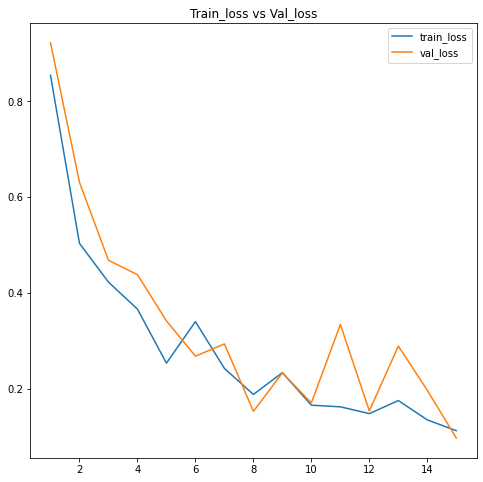

In [105]:
plt.figure(figsize= (8,8))
plt.plot(np.arange(1,16),train_loss, label = 'train_loss')
plt.plot(np.arange(1,16),val_loss, label = 'val_loss')
plt.legend()
plt.title('Train_loss vs Val_loss')

Text(0.5, 1.0, 'Train_accuracy vs Val_accuracy')

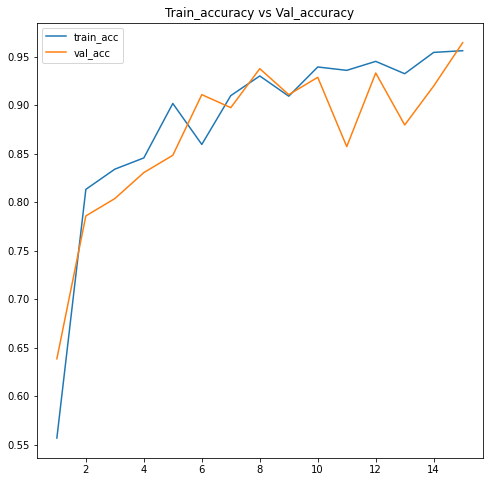

In [104]:
plt.figure(figsize= (8,8))
plt.plot(np.arange(1,16),train_acc, label = 'train_acc')
plt.plot(np.arange(1,16),val_acc, label = 'val_acc')
plt.legend()
plt.title('Train_accuracy vs Val_accuracy')

# Predictions

Prediction on a Single image

True label is: Potato___healthy
Predicted label is: Potato___healthy


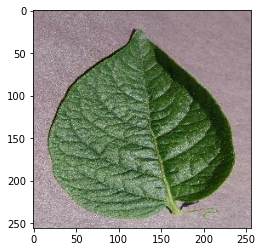

In [110]:
for img_batch, label_batch in testset.take(1):
    print('True label is:',classes[label_batch[0].numpy()])
    plt.imshow(img_batch[0].numpy().astype('uint8'))
    batch_pred = model.predict(img_batch)
    print('Predicted label is:', classes[np.argmax(batch_pred[0])])

Prediction for a batch of images using a function 

In [111]:
from keras.preprocessing import image

In [112]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

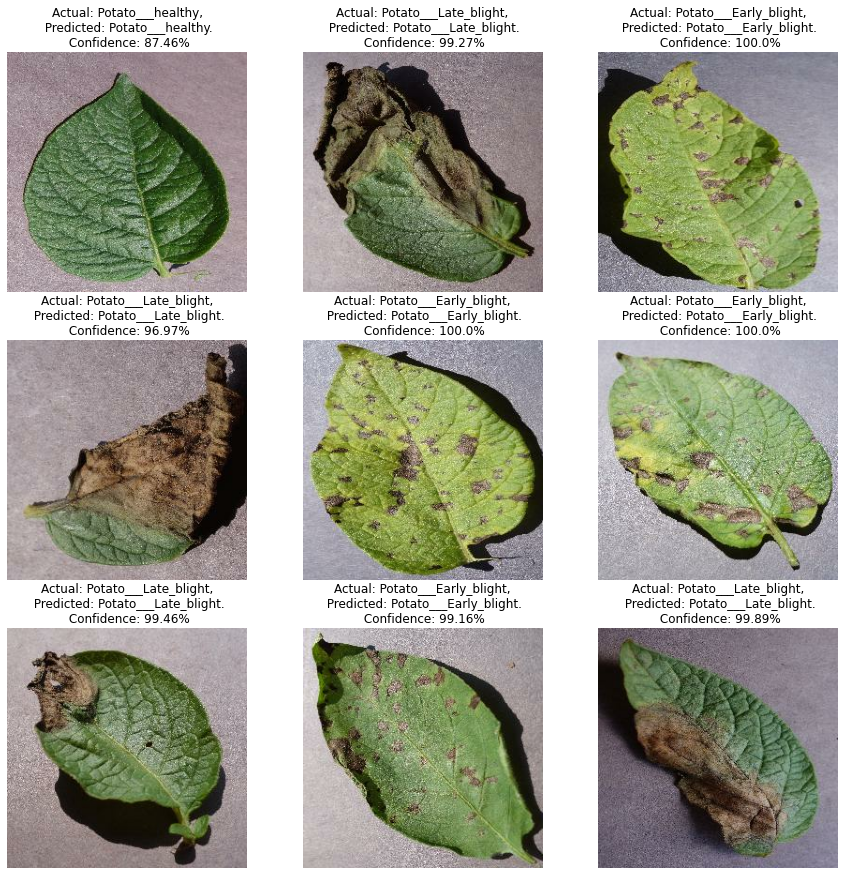

In [113]:
plt.figure(figsize=(15, 15))
for images, labels in testset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classes[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Saving the model

In [115]:
import os
model_version=max([int(i) for i in os.listdir("./models") + [0]])+1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/1\assets


In [ ]:
model.save("../potatoes.h5")